# [IAFlash](https://entrepreneur-interet-general.etalab.gouv.fr/defis/2019/iaflash.html) simple exploration

## Intelligence

We will give a try to transfer learning, using `Keras`.  
Specifically, we will reuse model `XXX` from Keras [model zoo](https://keras.io/applications/), and perform standard data augmentation using [`keras.preprocessing.image.ImageDataGenerator`](https://keras.io/preprocessing/image/) (see e.g. [here](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/) for use examples).

### Imports

In [1]:
import os
HOME = os.path.expanduser('~/')
HOST = os.uname()[1]
if HOST == 'Arthurs-MacBook-Pro.local':
    os.chdir(os.path.join(HOME, 'Documents/GitHub/EIG3_IAFlash/'))    # @home
else:
    raise ValueError('unknown host: {}'.format(HOST))
    
import numpy as np
import re
# import pandas as pd
import time
import pickle
from PIL import Image

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import densenet
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K

from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
%matplotlib inline

# from IAFlash.helpers import DataHandler, ImageWorker # needs correct working directory

Using TensorFlow backend.


### Variables

In [84]:
# data
if HOST == 'Arthurs-MacBook-Pro.local':
    pathToDataDir = os.path.join(HOME, 'Documents/Dropbox/Transit/EIG3_IAFlash/Patches/edge128bwFalseresampleFilter0') # (small) MobileNet
#     pathToDataDir = os.path.join(HOME, 'Documents/Dropbox/Transit/EIG3_IAFlash/Patches/edge128bwTrueresampleFilter0') # dummy model
#     pathToDataDir = os.path.join(HOME, 'Documents/Dropbox/Transit/EIG3_IAFlash/Patches/edge299bwFalseresampleFilter0') # InceptionV3
    pathToIntellDir = os.path.join(HOME, 'Documents/GitHub/EIG3_IAFlash/IAFlash/Intelligence/')
else:
    raise ValueError('unknown host: {}'.format(HOST))
data_format = 'channels_last'
nbClass = 196

# image processing
edge = int(re.findall('edge([0-9]*)',pathToDataDir)[0])
if 'bwTrue' in pathToDataDir:
    mode = 'grayscale'
elif 'bwFalse' in pathToDataDir:
    mode = 'rgb'
else:
    raise ValueError('color mode not undestood from data directory name')
    
# model compilation params
loss = 'categorical_crossentropy'
#optim = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#optim = Adamax()
optim = 'adam'
metric = ['accuracy']

# model training params
epochs = 10
earlystop = EarlyStopping(monitor='val_acc',
                          min_delta=0,
                          patience=20,
                          verbose=1)
checkpoint = ModelCheckpoint(os.path.join(pathToIntellDir, 'model_v0.hdf5'),
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             period=1)
reducelr = ReduceLROnPlateau(monitor='val_acc',
                             factor=0.1,
                             patience=4,
                             verbose=1)

# seed
seed = 8
np.random.seed(seed)

### Intelligence

**Data augmentation**

The [`keras.preprocessing.image.ImageDataGenerator`](https://keras.io/preprocessing/image/) object allows to augment data easily. Depending on the method used, data augmentation can be done once-for-all or on-the-fly. We will choose on-the-fly augmentation to avoid storing to large data.

In [3]:
# prepare a dataset augmenter
batch_size = 32

# NB: only train data need augmentation
train_datagen = ImageDataGenerator(featurewise_center=False,
                                   samplewise_center=False,
                                   featurewise_std_normalization=False,
                                   samplewise_std_normalization=False,
                                   zca_whitening=False, # explore this later
                                   zca_epsilon=1e-06,
                                   rotation_range=20, # 0
                                   width_shift_range=0.0,
                                   height_shift_range=0.0,
                                   shear_range=0.0,
                                   zoom_range=0.0,
                                   channel_shift_range=0.0,
                                   fill_mode='constant', #'nearest',
                                   cval=0.0,
                                   horizontal_flip=True, # False
                                   vertical_flip=False,
                                   rescale=1./255, # None
                                   preprocessing_function=None,
                                   data_format=data_format)

train_generator = train_datagen.flow_from_directory(os.path.join(pathToDataDir, 'Train'), # "it should contain one subdirectory per class"
                                                    target_size=(edge, edge),
                                                    color_mode=mode,
                                                    classes=None, # will infer from the directory structure
                                                    class_mode='categorical',
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=seed,
                                                    follow_links=False,
                                                    interpolation='nearest',
#                                                     save_to_dir=pathToDataDir, # use this to print one batch when calling train_generator[batchIdx]
#                                                     save_prefix='train_',      #
#                                                     save_format='png'          #
                                                   )

# NB: validation data use `ImageDataGenerator` for the conveniance of directory parsing
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(os.path.join(pathToDataDir, 'Validation'),
                                                              target_size=(edge, edge),
                                                              color_mode=mode,
                                                              class_mode='categorical',
                                                              batch_size=1, # most basic behaviour
                                                              seed=seed,
#                                                               save_to_dir=pathToDataDir, # use this to print one batch when calling validation_generator[batchIdx]
#                                                               save_prefix='valid_',      #
#                                                               save_format='png'          #
                                                             )

# NB: same thing for test data
test_datagen = validation_datagen

test_generator = test_datagen.flow_from_directory(os.path.join(pathToDataDir, 'Test'),
                                                  target_size=(edge, edge),
                                                  color_mode=mode,
                                                  class_mode='categorical',
                                                  batch_size=1, # most basic behaviour
                                                  seed=seed)

Found 8144 images belonging to 196 classes.
Found 1632 images belonging to 196 classes.
Found 6409 images belonging to 196 classes.


train data:


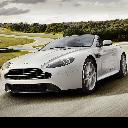

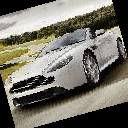

validation data (should not change):


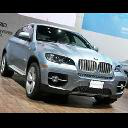

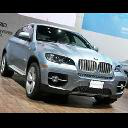

In [6]:
# example of data augmentation
i = 300

print('train data:')
im = Image.open(os.path.join(pathToDataDir, 'Train', train_generator.filenames[i]))
x_im = np.array(im)
if 2 == x_im.ndim: x_im = x_im.reshape((edge, edge, 1))
x_im_t = train_datagen.random_transform(x_im, seed=np.random.choice(100,1)[0])
if 1 == x_im_t.shape[-1]: x_im_t = x_im_t.reshape(edge, edge)
im_t = Image.fromarray(x_im_t)

display(im)
display(im_t)

print('validation data (should not change):')
im = Image.open(os.path.join(pathToDataDir, 'Validation', validation_generator.filenames[i]))
x_im = np.array(im)
if 2 == x_im.ndim: x_im = x_im.reshape((edge, edge, 1))
x_im_t = validation_datagen.random_transform(x_im, seed=np.random.choice(100,1)[0])
if 1 == x_im_t.shape[-1]: x_im_t = x_im_t.reshape(edge, edge)
im_t = Image.fromarray(x_im_t)

display(im)
display(im_t)

**Model**

In [7]:
# # build a basic model

# model = Sequential()
# model.add(Conv2D(input_shape=train_generator.image_shape,
#                  filters=1,
#                  kernel_size=9,
#                  strides=1,
#                  padding='same',
#                  data_format=train_generator.data_format,
#                  dilation_rate=1,
#                  activation=None, # explicit it later
#                  use_bias=True,
#                  kernel_initializer='glorot_uniform',
#                  bias_initializer='zeros',
#                  kernel_regularizer=None,
#                  bias_regularizer=None,
#                  activity_regularizer=None,
#                  kernel_constraint=None,
#                  bias_constraint=None))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(3, 3),
#                        strides=None,
#                        padding='same',
#                        data_format=train_generator.data_format))
# model.add(Flatten())
# model.add(Dense(train_generator.num_classes))
# model.add(Activation('softmax'))

# model.summary()

# # compile

# model.compile(loss=loss,
#               optimizer=optim,
#               metrics=metric)

# # train

# model_history = model.fit_generator(train_generator,
#                                     epochs=epochs,
#                                     steps_per_epoch=int(train_generator.n/train_generator.batch_size), # as advised in docstring
#                                     validation_data=validation_generator,
#                                     validation_steps=int(validation_generator.n/validation_generator.batch_size), # as advised in docstring
#                                     callbacks=[earlystop,checkpoint,reducelr])

Now try transfer learning.

Start with [InceptionV3](https://www.google.com/search?q=INceptionV3&hl=en&source=lnms&tbm=isch&sa=X&ved=0ahUKEwjTqfH817PeAhUPWBoKHcYBAcAQ_AUIDigB&biw=1326&bih=814&dpr=2#imgrc=EuTMi0p_uFctRM:), following this [example](https://keras.io/applications/#inceptionv3).

In [8]:
# from keras.applications.inception_v3 import InceptionV3
# # from keras.preprocessing import image
# from keras.models import Model
# from keras.layers import Dense, GlobalAveragePooling2D
# # from keras import backend as K

# # create the base pre-trained model
# base_model = InceptionV3(input_shape=train_generator.image_shape,
#                          weights='imagenet',
#                          include_top=False)

# # add a global spatial average pooling layer
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# # let's add a fully-connected layer
# # x = Dense(train_generator.num_classes, activation='relu')(x)
# # and a logistic layer -- let's say we have 200 classes
# predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# # this is the model we will train
# model = Model(inputs=base_model.input, outputs=predictions)


# # first: train only the top layers (which were randomly initialized)
# # i.e. freeze all convolutional InceptionV3 layers
# for layer in base_model.layers:
#     layer.trainable = False

# # compile the model (should be done *after* setting layers to non-trainable)
# model.compile(loss=loss,
#               optimizer=optim,
#               metrics=metric)

# # train for a few epochs
# model_history = model.fit_generator(train_generator,
#                                     epochs=epochs,
#                                     steps_per_epoch=int(train_generator.n/train_generator.batch_size), # as advised in docstring
#                                     validation_data=validation_generator,
#                                     validation_steps=int(validation_generator.n/validation_generator.batch_size), # as advised in docstring
#                                     callbacks=[earlystop,checkpoint,reducelr])

# # # at this point, the top layers are well trained and we can start fine-tuning
# # # convolutional layers from inception V3. We will freeze the bottom N layers
# # # and train the remaining top layers.

# # # let's visualize layer names and layer indices to see how many layers
# # # we should freeze:
# # for i, layer in enumerate(base_model.layers):
# #    print(i, layer.name)

# # # we chose to train the top 2 inception blocks, i.e. we will freeze
# # # the first 249 layers and unfreezethe rest:
# # for layer in model.layers[:249]:
# #    layer.trainable = False
# # for layer in model.layers[249:]:
# #    layer.trainable = True

# # # we need to recompile the model for these modifications to take effect
# # # we use SGD with a low learning rate
# # from keras.optimizers import SGD
# # model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# # # we train our model again (this time fine-tuning the top 2 inception blocks
# # # alongside the top Dense layers
# # model.fit_generator(...)

Try [MobileNet](https://keras.io/applications/#mobilenet).

In [74]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_21
1 conv1
2 conv1_bn
3 conv1_relu
4 conv_dw_1
5 conv_dw_1_bn
6 conv_dw_1_relu
7 conv_pw_1
8 conv_pw_1_bn
9 conv_pw_1_relu
10 conv_dw_2
11 conv_dw_2_bn
12 conv_dw_2_relu
13 conv_pw_2
14 conv_pw_2_bn
15 conv_pw_2_relu
16 conv_dw_3
17 conv_dw_3_bn
18 conv_dw_3_relu
19 conv_pw_3
20 conv_pw_3_bn
21 conv_pw_3_relu
22 conv_dw_4
23 conv_dw_4_bn
24 conv_dw_4_relu
25 conv_pw_4
26 conv_pw_4_bn
27 conv_pw_4_relu
28 conv_dw_5
29 conv_dw_5_bn
30 conv_dw_5_relu
31 conv_pw_5
32 conv_pw_5_bn
33 conv_pw_5_relu
34 conv_dw_6
35 conv_dw_6_bn
36 conv_dw_6_relu
37 conv_pw_6
38 conv_pw_6_bn
39 conv_pw_6_relu
40 conv_dw_7
41 conv_dw_7_bn
42 conv_dw_7_relu
43 conv_pw_7
44 conv_pw_7_bn
45 conv_pw_7_relu
46 conv_dw_8
47 conv_dw_8_bn
48 conv_dw_8_relu
49 conv_pw_8
50 conv_pw_8_bn
51 conv_pw_8_relu
52 conv_dw_9
53 conv_dw_9_bn
54 conv_dw_9_relu
55 conv_pw_9
56 conv_pw_9_bn
57 conv_pw_9_relu
58 conv_dw_10
59 conv_dw_10_bn
60 conv_dw_10_relu
61 conv_pw_10
62 conv_pw_10_bn
63 conv_pw_10_relu
64 conv_dw_11
65 

In [87]:
from keras.applications.mobilenet import MobileNet
# from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalMaxPooling2D
# from keras import backend as K


iLayerTrain = np.inf # 40

# create the base pre-trained model
base_model = MobileNet(input_shape=train_generator.image_shape,
                       weights='imagenet',
                       include_top=False,
                       alpha=1.0,
                       depth_multiplier=1,
                       dropout=0.001)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(int(x.shape[-1]), activation='relu')(x)
# and a softmax layer
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for i,layer in enumerate(base_model.layers):
    if i < iLayerTrain:
        layer.trainable = False

model.summary()
        
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(loss=loss,
              optimizer=optim,
              metrics=metric)

# train for a few epochs
model_history = model.fit_generator(train_generator,
                                    epochs=epochs,
                                    steps_per_epoch=int(train_generator.n/train_generator.batch_size), # as advised in docstring
                                    validation_data=validation_generator,
                                    validation_steps=int(validation_generator.n/validation_generator.batch_size), # as advised in docstring
                                    callbacks=[earlystop,checkpoint,reducelr])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 64, 64, 32)        0         
__________

Epoch 1/10
253/254 [============================>.] - ETA: 0s - loss: 4.9665 - acc: 0.0419
Epoch 00001: val_acc improved from 0.03309 to 0.06373, saving model to /Users/arthur/Documents/GitHub/EIG3_IAFlash/IAFlash/Intelligence/model_v0.hdf5
254/254 [==============================] - 207s 815ms/step - loss: 4.9647 - acc: 0.0418 - val_loss: 4.5581 - val_acc: 0.0637
Epoch 2/10
253/254 [============================>.] - ETA: 0s - loss: 3.8411 - acc: 0.1540
Epoch 00002: val_acc improved from 0.06373 to 0.06740, saving model to /Users/arthur/Documents/GitHub/EIG3_IAFlash/IAFlash/Intelligence/model_v0.hdf5
254/254 [==============================] - 166s 655ms/step - loss: 3.8404 - acc: 0.1543 - val_loss: 4.5667 - val_acc: 0.0674
Epoch 3/10
253/254 [============================>.] - ETA: 0s - loss: 3.2559 - acc: 0.2488
Epoch 00003: val_acc improved from 0.06740 to 0.08640, saving model to /Users/arthur/Documents/GitHub/EIG3_IAFlash/IAFlash/Intelligence/model_v0.hdf5
254/254 [==================

In [ ]:
# train for a more few epochs
model_history = model.fit_generator(train_generator,
                                    epochs=epochs,
                                    steps_per_epoch=int(train_generator.n/train_generator.batch_size), # as advised in docstring
                                    validation_data=validation_generator,
                                    validation_steps=int(validation_generator.n/validation_generator.batch_size), # as advised in docstring
                                    callbacks=[earlystop,checkpoint,reducelr])

**Performance assessment**

In [60]:
assess_generator = validation_generator
# assess_generator = test_generator # only in the end :)

assess_model = model

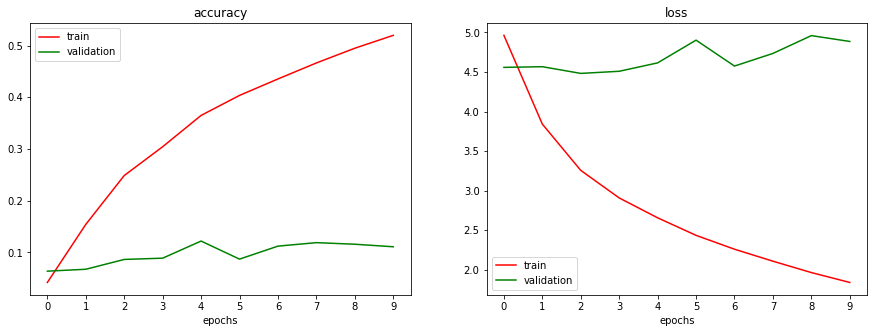

In [88]:
# plot the learning performance

f = plt.figure(figsize=(15,5))

ax = f.add_subplot(1,2,1)
ax.plot(model_history.history['acc'], 'r')
ax.plot(model_history.history['val_acc'], 'g')
ax.set_xticks(np.arange(0, epochs, 1))
ax.set_xlabel('epochs')
# ax.set_ylabel('accuracy')
ax.set_title('accuracy')
ax.legend(['train','validation'])
 
ax = f.add_subplot(1,2,2)
ax.plot(model_history.history['loss'], 'r')
ax.plot(model_history.history['val_loss'], 'g')
ax.set_xticks(np.arange(0, epochs, 1))
ax.set_xlabel('epochs')
# ax.set_ylabel('loss')
ax.set_title('loss')
ax.legend(['train','validation'])

plt.show()

In [89]:
# predictions

score = assess_model.predict_generator(assess_generator,
                                       steps=len(assess_generator),
                                       max_queue_size=10,
                                       workers=1,
                                       use_multiprocessing=False,
                                       verbose=1)
predicted = np.argmax(score, axis=1)

1632/1632 [==============================] - 56s 34ms/step



top 5 predictions for image 242 with true class 30:
   187 (0.16899093985557556)
   166 (0.10202986747026443)
   181 (0.10032300651073456)
   186 (0.07346763461828232)
   63 (0.06413472443819046)
correct class at rank: 68 out of 196

mean accuracy: 0.006127450980392157

confusion matrix


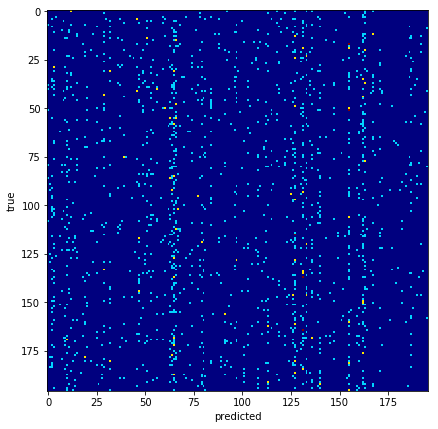


classification report


/Users/arthur/anaconda3/envs/tree/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [90]:
# ranked predictions
i,K = 242,5

true_i = assess_generator.classes[i]
score_i = score[i,:]
argsort_i = np.argsort(score_i)[::-1]
print('\ntop {} predictions for image {} with true class {}:'.format(K, i, true_i))
for k in range(K):
    print('   {} ({})'.format(argsort_i[k],score_i[argsort_i[k]]))
print('correct class at rank: {} out of {}'.format(1+np.where(argsort_i==true_i)[0][0], assess_generator.num_classes))

# accuracy
acc = np.mean(assess_generator.classes == predicted)
print('\nmean accuracy: {}'.format(acc))

# confusion matrix
print('\nconfusion matrix')
conf = confusion_matrix(assess_generator.classes, predicted)
f = plt.figure(figsize=(7, 7))
ax = f.add_subplot(1,1,1)
ax.imshow(conf, cmap=plt.cm.jet, interpolation='nearest')
ax.set_xlabel('predicted')
ax.set_ylabel('true')
plt.show()

print('\nclassification report')
report = classification_report(assess_generator.classes,
                               predicted,
                               target_names=np.sort(list(assess_generator.class_indices.keys())).tolist())
# print(report)
# print(classification_report_todf(report))

In [13]:
# import pandas as pd

# def classification_report_todf(report):
#     '''
#     inspired from https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format#41044355
#     '''
#     report_data = []
#     lines = report.split('\n')
#     for line in lines[2:-3]:
#         row = {}
#         row_data = line.split('      ')
#         row_data = list(filter(None, row_data))
#         row['class'] = row_data[0]
#         row['precision'] = float(row_data[1])
#         row['recall'] = float(row_data[2])
#         row['f1_score'] = float(row_data[3])
#         row['support'] = float(row_data[4])
#         report_data.append(row)
#     dataframe = pd.DataFrame.from_dict(report_data)
#     return dataframe

### Save material for client use

In [15]:
# data preprocessors
pickle.dump(test_datagen, open(os.path.join(pathToIntellDir, 'datagen.pkl'),'wb'))
pickle.dump(assess_generator.class_indices, open(os.path.join(pathToIntellDir, 'classesDict.pkl'),'wb'))

# model
assess_model.save(os.path.join(pathToIntellDir, 'model.h5'))